In [9]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
from sklearn import metrics
import pickle
import csv
import os
import matplotlib.pyplot as plt
import shutil

We follow the method laid out in the article: THE CANARY’S ECHO: AUDITING PRIVACY RISKS OF LLM-GENERATED SYNTHETIC TEXT, by Matthieu Meeus, Lukas Wutschitz, Santiago Zanella-Béguelin, Shruti Tople, Reza Shokri   

We use the gower distance for our tabular dataset.  

What we want to do to test RMIA:
1. Compute the RMIA score for each point in each train folder  
   RMIA = signal (provided DS) / signal (average of all reference models)
2. Get ground truths
3. Construct ROC curves, AUC, TPR at FPR

# Train the shadow models

16 shadow models were trained for each stage (train, dev, final).   

The first four models were trained as follows:
1. Initial training set includes 60,000 observations, but NONE of the observations included in the challenge lists of that repo. This is common to the four models.
2. TabDDPM is trained on that initial training set. This is common to the four models.
3. A new "fine-tuning" set is selected with exactly half of the observations included in the challenge lists of that repo for each of the four shadow models. Each observation is included in the fine-tuning set of exactly two (half) of the models. Each observation is repeated 12 times. Each set is shuffled.
4. The initial model is fine-tuned independently based on the new set to obtain each shadow model.
5. A synthetic dataset of 20K observations is generated for each model.

The following four models were trained in the same way, with a new initial training set in the hopes of increased performance (gain was minimal).

The following eight models were trained as follows, still in the hopes of increased performance with minimal gain:
1. Create eight training sets with exactly half of the observations included in the challenge lists of that repo for each of the eight models. Each observation is included in the training set of exactly four (half) of the models. Each observation is repeated 12 times. Each set is shuffled.
2. Train a new TabDDPM model for the eight shadow models.
3. A synthetic dataset of 20K observations is generated for each model.

The code used is in rmia_shadows.py for the first strategy and rmia_shadows_m8.py for the second strategy.

# Compute the membership signals

The code used to compute the gower matrix and the signals is in rmia_sim_shadows and rmia_sim_target.

# Compute the RMIA scores for all the challenge lists

In [12]:
# Where to find the training data and the shadow models trained on it (done for train, dev, final)
repo_path = '/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train'

In [ ]:
# Final code to compute the useful features and RMIA scores
k = 5

# Load lists of shadow models
# The dictionary contain the synthetic data generated using the model 
# and the observations included in the training set
with open(os.path.join(repo_path, 'rmia_shadows.pkl'), 'rb') as file:
    shadows_dict = pickle.load(file)
with open(os.path.join(repo_path, 'rmia_shadows_2.pkl'), 'rb') as file:
    shadows_dict_2 = pickle.load(file)
with open(os.path.join(repo_path, 'rmia_shadows_m8.pkl'), 'rb') as file:
    shadows_dict_m8 = pickle.load(file)

# shadow_lists will be the list of all training sets for the shadow models
shadow_lists = shadows_dict['fine_tuning_sets'] + shadows_dict_2['fine_tuning_sets'] + shadows_dict_m8['selected_sets']

# For each challenge list in the repo, compute the necessary RMIA (k=1, k=5, in, out)
for folder in os.listdir(repo_path):
    print(folder)
    folder_path = os.path.join(repo_path, folder)
    if os.path.isdir(folder_path) and 'tabddpm' in folder:

        # Load target
        filename = os.path.join(folder_path, 'gower_matrix.csv')
        gower_target = np.genfromtxt(filename, delimiter=',')

        # Target signals
        gower_target_closest = np.sort(gower_target, axis=1)[:, :k]
        signal_target = np.mean(gower_target_closest, axis=1)
        signal_target_k_1 = np.min(gower_target, axis=1)
        
        # Load shadows
        with open(os.path.join(folder_path, 'gower_matrix_shadow_top_10.pkl'), 'rb') as file:
            signal_shadows_dict = pickle.load(file)
        with open(os.path.join(folder_path, 'gower_matrix_shadow_2_top_1.pkl'), 'rb') as file:
            signal_shadows_dict_2 = pickle.load(file)
        with open(os.path.join(folder_path, 'gower_matrix_shadow_m8_top_5.pkl'), 'rb') as file:
            signal_shadows_dict_m8 = pickle.load(file)
        gower_shadows = np.vstack([np.array(signal_shadows_dict['gower_matrix']),
                                   np.array(signal_shadows_dict_2['gower_matrix']),
                                   np.array(signal_shadows_dict_m8['gower_matrix']),
                                  ])

        # Shadow signals
        mean_dist_shadow = np.mean(np.sort(gower_shadows, axis=2)[:, :, :k], axis=2)
        signal_shadows = np.mean(mean_dist_shadow, axis=0)
        
        min_dist_shadow = np.min(gower_shadows, axis=2)
        signal_shadows_k_1 = np.mean(min_dist_shadow, axis=0)
        
        signal_shadows = pd.DataFrame(signal_shadows, columns=['signal_shadow_k_'+str(k)])
        signal_shadows['signal_shadow_k_1'] = signal_shadows_k_1

        # Load trans_id
        challenge_df = pd.read_csv(os.path.join(folder_path, 'challenge_with_id.csv'))
        signal_shadows['trans_id'] = challenge_df['trans_id']

        # Shadow in and out signals
        # Create masks of shape (16, 200) where True means that shadow_lists[i] contains trans_id[j] 
        # for mask_in (and vice versa for mask_out)
        mask_in = np.array([[signal_shadows['trans_id'][j] in shadow_lists[i] for j in range(200)] for i in range(len(shadow_lists))])
        mask_out = np.array([[signal_shadows['trans_id'][j] not in shadow_lists[i] for j in range(200)] for i in range(len(shadow_lists))])
        
        # Compute the mean using only valid values (to get the membership signals)
        signal_shadows['signal_shadows_in_k_1'] = np.where(mask_in.sum(axis=0) > 0, 
                                      np.sum(min_dist_shadow * mask_in, axis=0) / mask_in.sum(axis=0),
                                      np.nan)  
        signal_shadows['signal_shadows_in_k_'+str(k)] = np.where(mask_in.sum(axis=0) > 0,  
                                      np.sum(mean_dist_shadow * mask_in, axis=0) / mask_in.sum(axis=0),
                                      np.nan)  
        signal_shadows['signal_shadows_out_k_1'] = np.where(mask_out.sum(axis=0) > 0,  
                                      np.sum(min_dist_shadow * mask_out, axis=0) / mask_out.sum(axis=0),
                                      np.nan)  
        signal_shadows['signal_shadows_out_k_'+str(k)] = np.where(mask_out.sum(axis=0) > 0, 
                                      np.sum(mean_dist_shadow * mask_out, axis=0) / mask_out.sum(axis=0),
                                      np.nan)  

        # RMIA computation and selection of useful features
        signal_shadows['signal_target_k_1'] = signal_target_k_1
        signal_shadows['signal_target_k_5'] = signal_target
        signal_shadows['rmia_k_1'] = signal_shadows['signal_target_k_1'] / signal_shadows['signal_shadow_k_1']
        signal_shadows['rmia_k_5'] = signal_shadows['signal_target_k_5'] / signal_shadows['signal_shadow_k_5']
        signal_shadows['rmia_out_k_1'] = signal_shadows['signal_target_k_1'] / signal_shadows['signal_shadows_out_k_1']
        signal_shadows['rmia_out_k_5'] = signal_shadows['signal_target_k_5'] / signal_shadows['signal_shadows_out_k_5']

        # Save to the original folder
        file_name = 'challenge_rmia_k1_k'+str(k)+'.csv'
        signal_shadows.to_csv(os.path.join(folder_path, file_name), header=True, index=False)


# Compare the performance of RMIA for different values of k

Here we compared the performance of RMIA for different values of k (before settling on k=1 and k=5).
We ran it twice (first with k=5 to 25 and then k=1 to 4) - we kept the two figures here.

In [ ]:
fpr_tpr_10_all_k_all_folders = []
all_k = np.arange(1, 5)  # Avoid redundant list creation

for folder in os.listdir(repo_path):
    print(folder)
    folder_path = os.path.join(repo_path, folder)
    if os.path.isdir(folder_path) and 'tabddpm' in folder:
        fpr_tpr_10_all_k = []
        
        # Load target
        filename = os.path.join(folder_path, 'gower_matrix.csv')
        gower_target = np.genfromtxt(filename, delimiter=',')

        # Load shadows
        with open(os.path.join(folder_path, 'gower_matrix_shadow_top_10.pkl'), 'rb') as file:
            signal_shadows_dict = pickle.load(file)
        with open(os.path.join(folder_path, 'gower_matrix_shadow_m8_top_5.pkl'), 'rb') as file:
            signal_shadows_m8_dict = pickle.load(file)
        gower_shadows = np.vstack([
                                    np.array(signal_shadows_dict['gower_matrix']),
                                    np.array(signal_shadows_m8_dict['gower_matrix'])
                                ])

        # Load labels
        df = pd.read_csv(os.path.join(folder_path, 'challenge_label.csv'))

        for k in all_k:
            print(k)
            # Target signals
            gower_target_closest = np.sort(gower_target, axis=1)[:, :k]
            signal_target = np.mean(gower_target_closest, axis=1)

            # Shadow signals
            mean_dist_shadow = np.mean(np.sort(gower_shadows, axis=2)[:, :, :k], axis=2)
            signal_shadows = np.mean(mean_dist_shadow, axis=0)

            # RMIA computation
            rmia = signal_target / signal_shadows
            df['rmia'] = rmia

            # Compute ROC curve & interpolate FPR at TPR = 0.1
            fpr, tpr, _ = metrics.roc_curve(df['is_train'], df['rmia'])
            fpr_at_tpr_0_1 = np.interp(0.1, tpr, fpr)

            fpr_tpr_10_all_k.append(fpr_at_tpr_0_1) 

        fpr_tpr_10_all_k_all_folders.append(fpr_tpr_10_all_k)

# Now, compute the mean across all folders for each k
fpr_tpr_10_mean = np.mean(fpr_tpr_10_all_k_all_folders, axis=0)


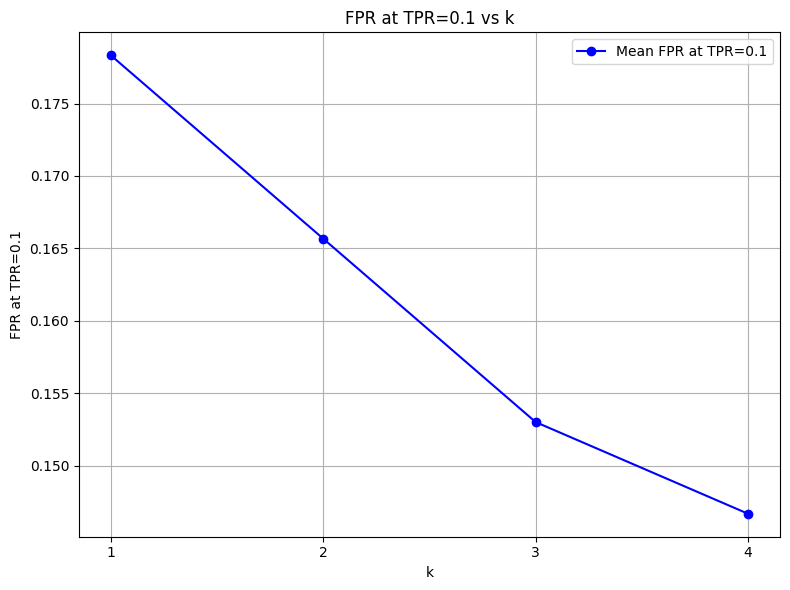

In [365]:
# Plot the mean FPR at TPR = 0.1 for each k
# The output here is when we ran it for k=1 to k=4
plt.figure(figsize=(8, 6))
plt.plot(all_k, fpr_tpr_10_mean, marker='o', color='b', label='Mean FPR at TPR=0.1')
plt.xlabel('k')
plt.ylabel('FPR at TPR=0.1')
plt.title('FPR at TPR=0.1 vs k')
plt.grid(True)
plt.legend()

# Set x-axis ticks to show integers only
plt.xticks(all_k)

plt.tight_layout()
plt.show()

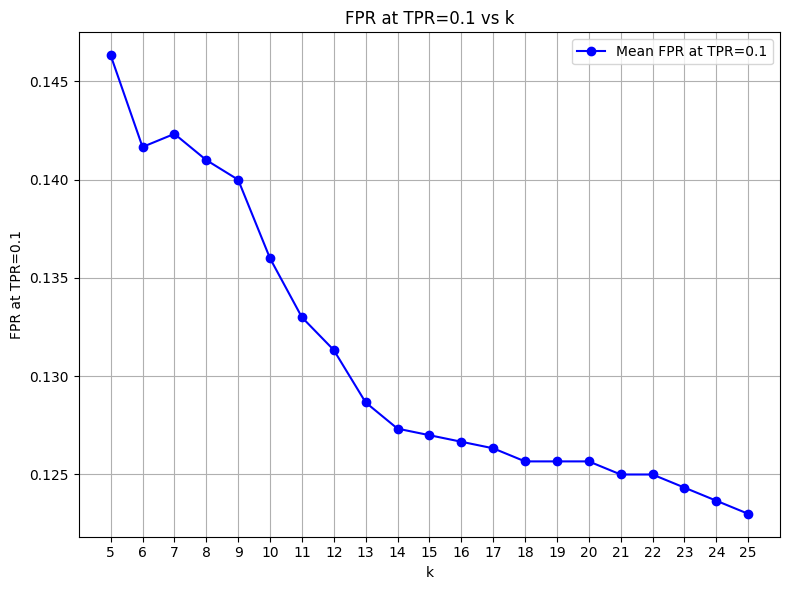

In [66]:
# Plot the mean FPR at TPR = 0.1 for each k
# The output here is when we ran it for k=5 to k=25
plt.figure(figsize=(8, 6))
plt.plot(all_k, fpr_tpr_10_mean, marker='o', color='b', label='Mean FPR at TPR=0.1')
plt.xlabel('k')
plt.ylabel('FPR at TPR=0.1')
plt.title('FPR at TPR=0.1 vs k')
plt.grid(True)
plt.legend()

# Set x-axis ticks to show integers only
plt.xticks(all_k)

plt.tight_layout()
plt.show()

# Run RMIA for the training set of the metaclassifier

Steps:
1. create the training dataset made up of all the challenge points with is_train=1 in the train repo + points that are not in challenge_points to complete (the final dataset must contain 20K observations)  
Location of the challenge points: /data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/metaclassifier_target_model_rmia/master_challenge.csv
3. generate 20K synthetic data points which become the "true" synthetic data  
Location: /data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/metaclassifier_target_model_rmia/synthetic_data.csv
5. compute the gower distance and the membership signals wrt these new synthetic data points

In [98]:
# update the repo path
repo_path = '/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train'

In [367]:
master_gower_matrix_target = np.genfromtxt('/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/metaclassifier_target_model_rmia/gower_matrix.csv',
                                           delimiter=',')
master_signal_target = np.genfromtxt('/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/metaclassifier_target_model_rmia/mean_gower_distance_top_5.csv', 
                              delimiter=',')

In [ ]:
signal_shadows_all = []
k = 5

master_challenge = pd.read_csv('/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/metaclassifier_target_model_rmia/master_challenge.csv')
master_signal_target = pd.DataFrame({'trans_id': master_challenge['trans_id'],
                                     'signal_target_k_5': master_signal_target,
                                     'signal_target_k_1': np.min(master_gower_matrix_target, axis=1)})

# Load lists of shadow models
with open(os.path.join(repo_path, 'rmia_shadows.pkl'), 'rb') as file:
    shadows_dict = pickle.load(file)
with open(os.path.join(repo_path, 'rmia_shadows_2.pkl'), 'rb') as file:
    shadows_dict_2 = pickle.load(file)
with open(os.path.join(repo_path, 'rmia_shadows_m8.pkl'), 'rb') as file:
    shadows_dict_m8 = pickle.load(file)

# Concatenate the lists of observations included in the training of the shadow models
shadow_lists = shadows_dict['fine_tuning_sets'] + shadows_dict_2['fine_tuning_sets'] + shadows_dict_m8['selected_sets']
len(shadow_lists)

for folder in os.listdir(repo_path):
    print(folder)
    folder_path = os.path.join(repo_path, folder)
    if os.path.isdir(folder_path) and 'tabddpm' in folder:
        
        # Load the membership signals for all shadow models
        with open(os.path.join(folder_path, 'gower_matrix_shadow_top_10.pkl'), 'rb') as file:
            signal_shadows_dict = pickle.load(file)
        with open(os.path.join(folder_path, 'gower_matrix_shadow_2_top_1.pkl'), 'rb') as file:
            signal_shadows_dict_2 = pickle.load(file)
        with open(os.path.join(folder_path, 'gower_matrix_shadow_m8_top_5.pkl'), 'rb') as file:
            signal_shadows_dict_m8 = pickle.load(file)
        gower_shadows = np.vstack([np.array(signal_shadows_dict['gower_matrix']),
                                   np.array(signal_shadows_dict_2['gower_matrix']),
                                   np.array(signal_shadows_dict_m8['gower_matrix']),
                                  ])

        # Shadow signals
        mean_dist_shadow = np.mean(np.sort(gower_shadows, axis=2)[:, :, :k], axis=2)
        signal_shadows = np.mean(mean_dist_shadow, axis=0)
        
        min_dist_shadow = np.min(gower_shadows, axis=2)
        signal_shadows_k_1 = np.mean(min_dist_shadow, axis=0)
        
        signal_shadows = pd.DataFrame(signal_shadows, columns=['signal_shadow_k_'+str(k)])
        signal_shadows['signal_shadow_k_1'] = signal_shadows_k_1

        # Load trans_id
        challenge_df = pd.read_csv(os.path.join(folder_path, 'challenge_with_id.csv'))
        signal_shadows['trans_id'] = challenge_df['trans_id']

        # Shadow in and out signals
        # Step 1: Create mask of shape (16, 200) where True means that shadow_lists[i] contains trans_id[j]
        mask_in = np.array([[signal_shadows['trans_id'][j] in shadow_lists[i] for j in range(200)] for i in range(len(shadow_lists))])
        mask_out = np.array([[signal_shadows['trans_id'][j] not in shadow_lists[i] for j in range(200)] for i in range(len(shadow_lists))])
        
        # Step 2: Compute mean using only valid values
        signal_shadows['signal_shadows_in_k_1'] = np.where(mask_in.sum(axis=0) > 0,
                                      np.sum(min_dist_shadow * mask_in, axis=0) / mask_in.sum(axis=0),
                                      np.nan)  
        signal_shadows['signal_shadows_in_k_'+str(k)] = np.where(mask_in.sum(axis=0) > 0,
                                      np.sum(mean_dist_shadow * mask_in, axis=0) / mask_in.sum(axis=0),
                                      np.nan)  
        signal_shadows['signal_shadows_out_k_1'] = np.where(mask_out.sum(axis=0) > 0, 
                                      np.sum(min_dist_shadow * mask_out, axis=0) / mask_out.sum(axis=0),
                                      np.nan)  
        signal_shadows['signal_shadows_out_k_'+str(k)] = np.where(mask_out.sum(axis=0) > 0, 
                                      np.sum(mean_dist_shadow * mask_out, axis=0) / mask_out.sum(axis=0),
                                      np.nan) 

        signal_shadows_all.append(signal_shadows)

master_signal_shadow = pd.concat(signal_shadows_all, ignore_index=True).drop_duplicates()

In [137]:
# Load the true labels
master_challenges_labels = pd.read_csv('/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/metaclassifier_target_model_rmia/master_challenge_labels.csv')

In [386]:
master_signal_target.columns

Index(['trans_id', 'signal_target_k_5', 'signal_target_k_1'], dtype='object')

In [387]:
# Create a dataframe with the signals and the labels
master_signal = master_challenge.merge(master_signal_shadow, on='trans_id', how='left')
master_signal = master_signal.merge(master_signal_target, on='trans_id', how='left')
master_signal = master_signal[['trans_id', 
                               'signal_target_k_1', 'signal_target_k_5',
                               'signal_shadow_k_1', 'signal_shadow_k_5',
                               'signal_shadows_in_k_1', 'signal_shadows_in_k_5',
                               'signal_shadows_out_k_1', 'signal_shadows_out_k_5']]
master_signal = master_signal.drop_duplicates(subset='trans_id', keep='first').reset_index(drop=True).copy()

In [388]:
# RMIA computation
master_signal['rmia_k_1'] = master_signal['signal_target_k_1'] / master_signal['signal_shadow_k_1']
master_signal['rmia_k_5'] = master_signal['signal_target_k_5'] / master_signal['signal_shadow_k_5']
master_signal['rmia_out_k_1'] = master_signal['signal_target_k_1'] / master_signal['signal_shadows_out_k_1']
master_signal['rmia_out_k_5'] = master_signal['signal_target_k_5'] / master_signal['signal_shadows_out_k_5']

# Compute ROC curve & interpolate FPR at TPR = 0.1, using the RMIA with k=1 as the probability
fpr, tpr, _ = metrics.roc_curve(master_challenges_labels['is_train'], master_signal['rmia_k_1'])
fpr_at_tpr_0_1 = np.interp(0.1, tpr, fpr)

fpr_at_tpr_0_1

0.1873324396782842

In [389]:
# Compute ROC curve & interpolate FPR at TPR = 0.1, using the RMIA with k=5 as the probability
fpr, tpr, _ = metrics.roc_curve(master_challenges_labels['is_train'], master_signal['rmia_k_5'])
fpr_at_tpr_0_1 = np.interp(0.1, tpr, fpr)

fpr_at_tpr_0_1

0.1427613941018767

In [391]:
# Compute ROC curve & interpolate FPR at TPR = 0.1, 
# using the RMIA with k=1 as the probability,
# and only including shadow models that do not include the point in their training set in the denominator
fpr, tpr, _ = metrics.roc_curve(master_challenges_labels['is_train'], master_signal['rmia_out_k_1'])
fpr_at_tpr_0_1 = np.interp(0.1, tpr, fpr)

fpr_at_tpr_0_1

0.19101876675603216

In [392]:
# Compute ROC curve & interpolate FPR at TPR = 0.1 using the RMIA with k=5 as the probability,
# and only including shadow models that do not include the point in their training set in the denominator
fpr, tpr, _ = metrics.roc_curve(master_challenges_labels['is_train'], master_signal['rmia_out_k_5'])
fpr_at_tpr_0_1 = np.interp(0.1, tpr, fpr)

fpr_at_tpr_0_1

0.14912868632707774

In [394]:
# Save master dataframe
file_name = 'master_challenge_rmia_k1_k5.csv'
master_signal.to_csv(os.path.join('/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/metaclassifier_target_model_rmia', 
                        file_name),
                     header=True, index=False)

In [399]:
master_signal.columns

Index(['trans_id', 'signal_target_k_1', 'signal_target_k_5',
       'signal_shadow_k_1', 'signal_shadow_k_5', 'signal_shadows_in_k_1',
       'signal_shadows_in_k_5', 'signal_shadows_out_k_1',
       'signal_shadows_out_k_5', 'rmia_k_1', 'rmia_k_5', 'rmia_out_k_1',
       'rmia_out_k_5'],
      dtype='object')

# To send

In [419]:
# Create the master directory
repo_path = "/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train"

master_dir = os.path.join(repo_path, "train_master_challenge_rmia_k1_k5")
os.makedirs(master_dir, exist_ok=True)

# Get all folders containing "tabddpm" in their name
folders = [f for f in os.listdir(repo_path) if "tabddpm" in f and os.path.isdir(os.path.join(repo_path, f))]

# Copy and rename the files
for folder in folders:
    src_file = os.path.join(repo_path, folder, "challenge_rmia_k1_k5.csv")
    if os.path.exists(src_file):
        dest_file = os.path.join(master_dir, f"challenge_rmia_k1_k5_{folder}.csv")
        shutil.copy2(src_file, dest_file) 

print(f"Copied {len(folders)} files to {master_dir}")

zip_name = master_dir 
shutil.make_archive(zip_name, 'zip', master_dir)

Copied 30 files to /data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/train_master_challenge_rmia_k1_k5
Zipped folder into /data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/train_master_challenge_rmia_k1_k5.zip
